In [1]:
import pandas as pd
import xgboost as xgb
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,Standardized_SMILES,pchembl_value,MolWt,LogP,QED
0,CC(C)c1nnc2ccc(-c3c[nH]nc3-c3cc(F)ccc3F)cn12,8.55,339.349,4.18800,0.608797
1,CC(=O)Nc1cnccc1CCOc1ccc(NC(=O)N=c2cc(C(C)(C)C)...,8.10,576.701,6.67222,0.200740
2,Cc1ccc(-n2[nH]c(C(C)(C)C)cc2=NC(=O)Nc2ccc(OCCN...,7.81,527.669,5.40832,0.351338
3,O=c1ncc2c(-c3ccccc3Cl)cc(C(O)N3CCNCC3)cc2n1-c1...,8.82,515.828,4.90900,0.404159
4,Cn1c(-c2cn(C(C)(C)C(=O)O)nn2)nc(-c2ccc(F)cc2)c...,5.83,406.421,3.36640,0.545632
...,...,...,...,...,...
1440,CCN(C(=O)c1csc2ccccc12)c1cc[nH]c(=NC(C)c2ccccc...,6.73,402.523,4.95300,0.513182
1441,COc1cc2[nH]cnc(=Nc3cc(NC(=O)c4ccnc(N5CCOCC5)c4...,7.30,597.720,4.46092,0.290574
1442,CN1CCC(c2cc(-c3ccc(F)cc3Cl)c3c(c2)N(c2c(Cl)ccc...,9.30,518.847,7.62340,0.386913
1443,Cc1ccc(C(=O)Nc2cccc(C(F)(F)F)c2C)cc1-c1ccc2[nH...,8.05,547.625,6.50444,0.289316


In [2]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [3]:
smiles = df['Standardized_SMILES'].values

In [4]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [5]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
0,CC(C)c1nnc2ccc(-c3c[nH]nc3-c3cc(F)ccc3F)cn12,8.55,339.349,4.18800,0.608797,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(=O)Nc1cnccc1CCOc1ccc(NC(=O)N=c2cc(C(C)(C)C)...,8.10,576.701,6.67222,0.200740,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,Cc1ccc(-n2[nH]c(C(C)(C)C)cc2=NC(=O)Nc2ccc(OCCN...,7.81,527.669,5.40832,0.351338,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,O=c1ncc2c(-c3ccccc3Cl)cc(C(O)N3CCNCC3)cc2n1-c1...,8.82,515.828,4.90900,0.404159,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Cn1c(-c2cn(C(C)(C)C(=O)O)nn2)nc(-c2ccc(F)cc2)c...,5.83,406.421,3.36640,0.545632,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1440,CCN(C(=O)c1csc2ccccc12)c1cc[nH]c(=NC(C)c2ccccc...,6.73,402.523,4.95300,0.513182,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1441,COc1cc2[nH]cnc(=Nc3cc(NC(=O)c4ccnc(N5CCOCC5)c4...,7.30,597.720,4.46092,0.290574,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1442,CN1CCC(c2cc(-c3ccc(F)cc3Cl)c3c(c2)N(c2c(Cl)ccc...,9.30,518.847,7.62340,0.386913,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1443,Cc1ccc(C(=O)Nc2cccc(C(F)(F)F)c2C)cc1-c1ccc2[nH...,8.05,547.625,6.50444,0.289316,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
#Now incorporate this sort of noise into df during the training

In [7]:
X.shape

(1445, 2048)

In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample
    
    
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        
        model = xgb.XGBRegressor(n_estimators=min(25, round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("unsorted_fcv_results_xgboost_training batches.csv", index=False)
    test_df.to_csv("unsorted_fcv_results_xgboost_testing batches.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

In [9]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

(0.6884286799227188, 1.5057044013571313e-21)
(0.8026364184059243, 1.1279726261960036e-33)
(0.8210494975086278, 2.168191420754037e-36)
(0.7248935276742382, 9.478823649531252e-25)
(0.8189817739850264, 4.53299255748544e-36)
(0.8459044269721336, 1.350438029768437e-40)
(0.8460341902185644, 1.2782034474846604e-40)
(0.803921576225644, 7.449923793908655e-34)
(0.8622689720613651, 2.804488214983044e-45)


In [10]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(2, 3)
(2, 3)
(4, 3)
(0, 3)
(0, 3)
(5, 3)
(0, 3)
(0, 3)
(3, 3)


In [11]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(1, 3)
(0, 3)
(0, 3)
(0, 3)
(1, 3)
(1, 3)
(2, 3)
(0, 3)
(1, 3)


In [12]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(0, 3)
(6, 3)
(2, 3)
(4, 3)
(7, 3)
(5, 3)
(3, 3)
(5, 3)
(2, 3)


In [13]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(140, 3)
(135, 3)
(138, 3)
(140, 3)
(136, 3)
(133, 3)
(139, 3)
(138, 3)
(143, 3)


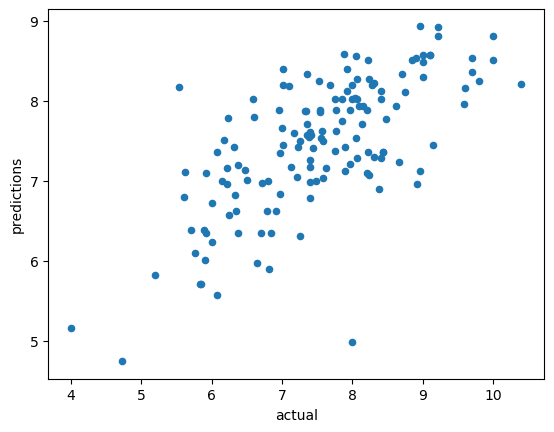

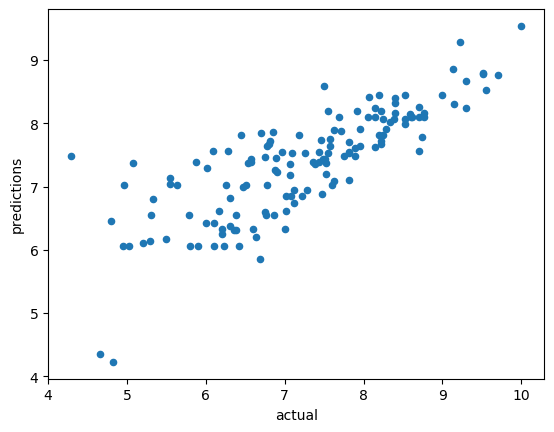

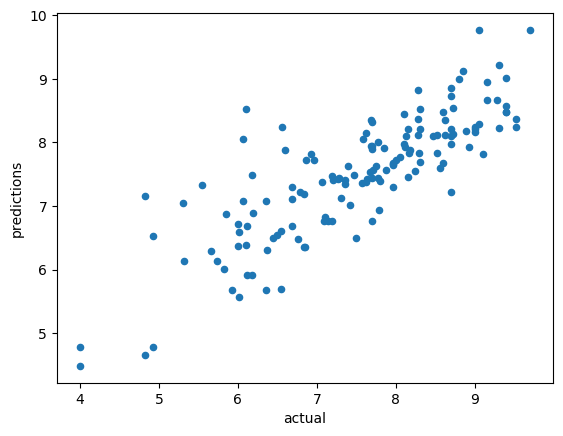

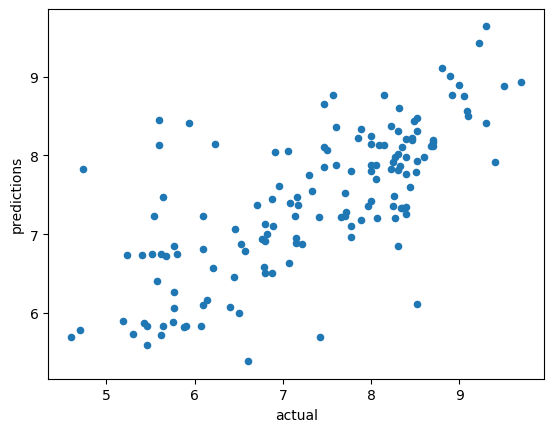

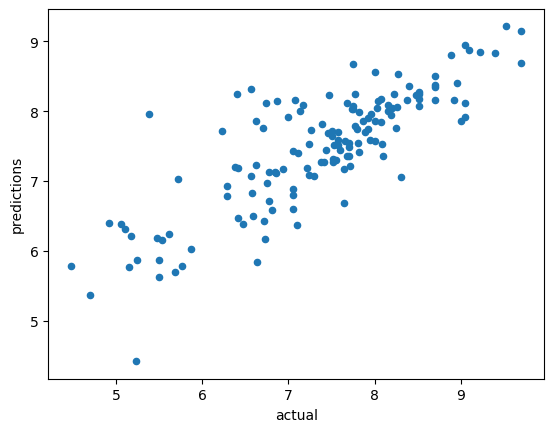

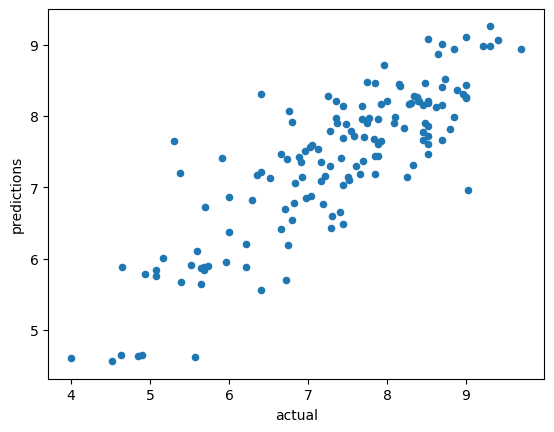

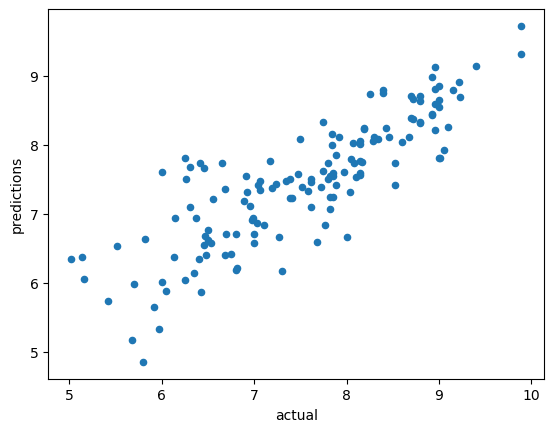

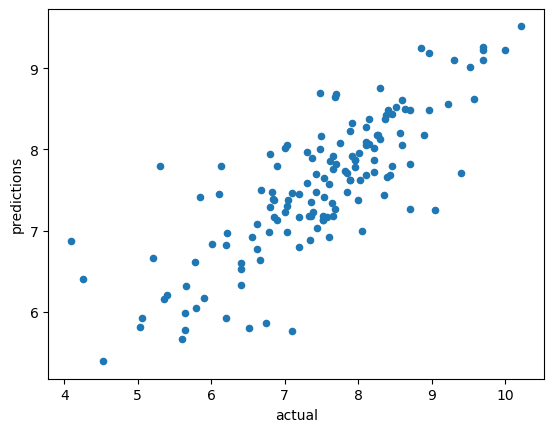

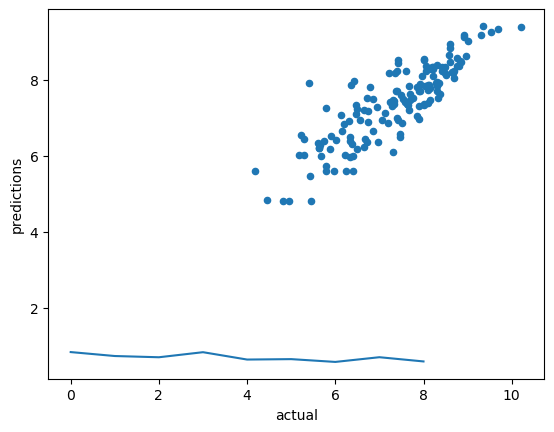

[0.8398250899019183, 0.7361507003239126, 0.7036693012355193, 0.8367427961549492, 0.6432938632748951, 0.6543314701157052, 0.581028373767857, 0.704826802473254, 0.5936694191339323]


In [14]:
plt.plot(rmse)
plt.show()
print(rmse)

In [15]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

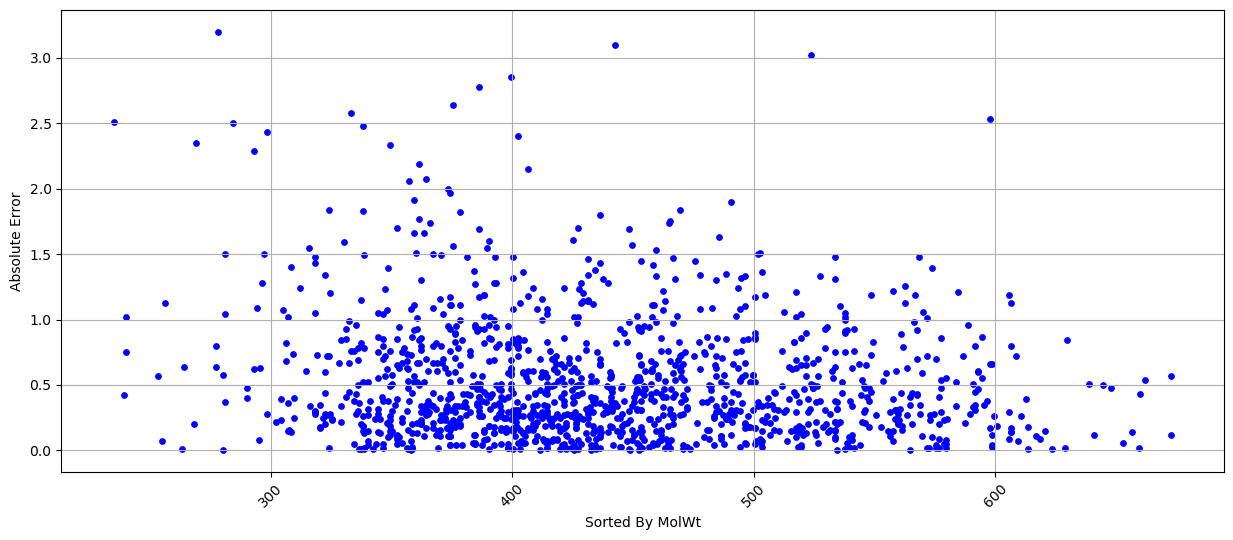

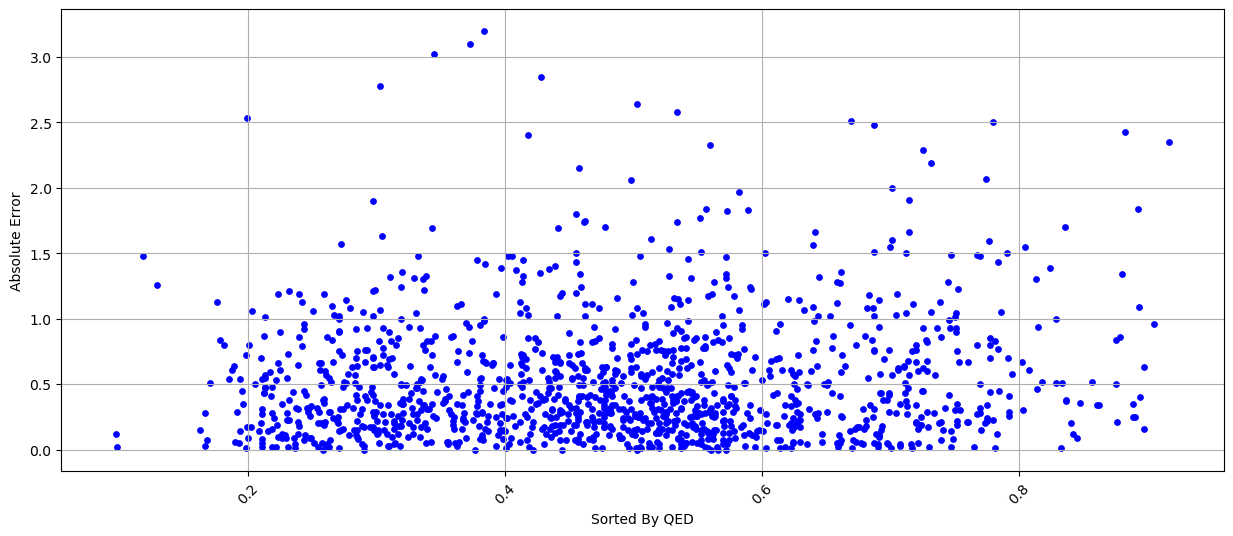

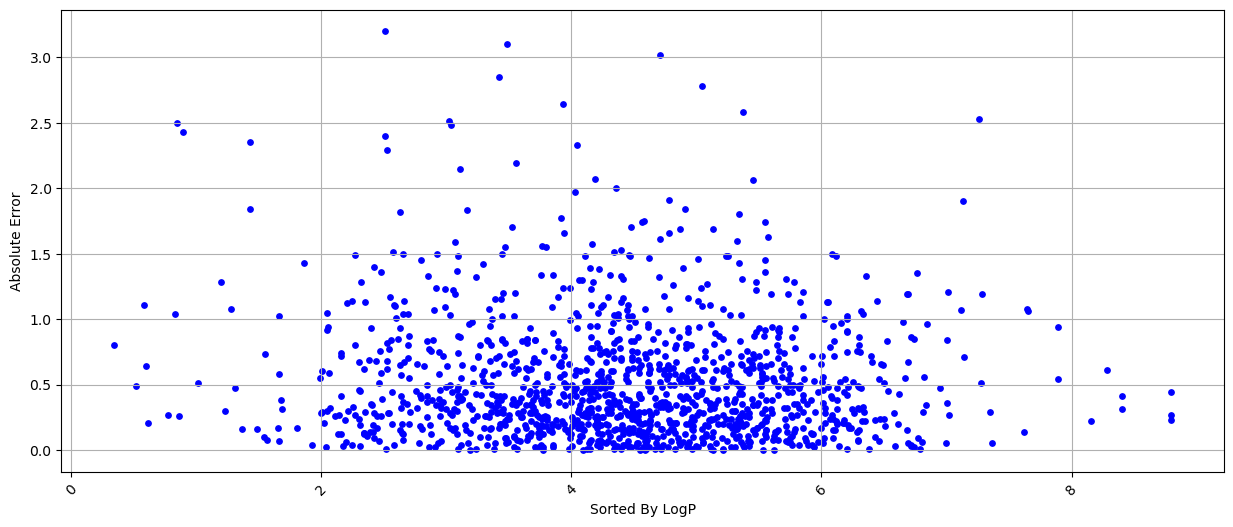

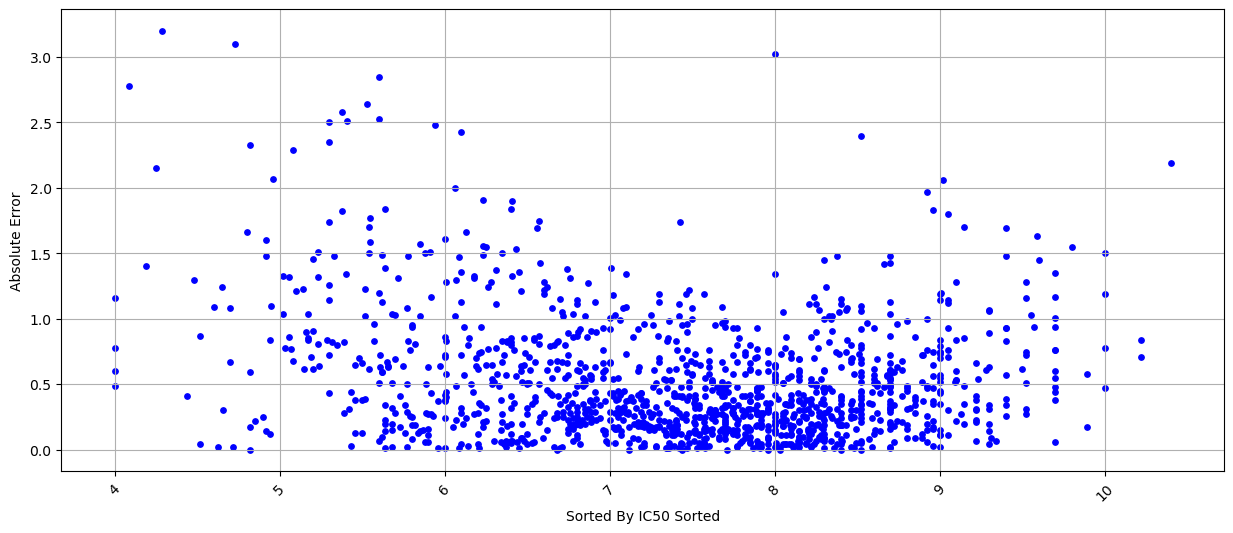

In [16]:
plot_graphs(df, results_df)

In [17]:
import random
df_copy=df.copy().sort_values(by="QED")#regular sort 
df_copy.plot(y="pchembl_value",use_index=False) #probabilities of each molecule being selected upon random selection without replacement
df_copy.plot(y="QED",use_index=False)

indices=df.nlargest(round(len(X)/10), ['QED']).index
X_test=X.copy()[indices]
y_test=y.copy()[indices]
smiles_test=smiles[indices]

X1=np.delete(X.copy(),indices,axis=0)
y1=np.delete(y.copy(),indices,axis=0)
smiles1=np.delete(smiles.copy(),indices,axis=0)


#X[df.nlargest(126, ['QED']).index].shape

In [18]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        

        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = xgb.XGBRegressor(n_estimators=min(25, round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("unsorted_fcv_results_xgboost_training batches_druglike.csv", index=False)
    test_df.to_csv("unsorted_fcv_results_xgboost_testing batches_druglike.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
    })


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

In [19]:


results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X1, y1, smiles1, sort_by=None, additional_info=df["QED"])

(0.5527131917361912, 6.839330561030767e-13)
(0.3964339913419087, 8.706885597133659e-07)
(0.47741535764752474, 1.446301874366492e-09)
(0.49540835145151074, 2.7411246322923096e-10)
(0.4853480545625713, 7.029972848379043e-10)
(0.5465954672442987, 1.3702324662592614e-12)
(0.543460431948006, 1.9457574098818874e-12)
(0.5248254203757867, 1.4541774503044644e-11)
(0.58912445921581, 8.034603803662008e-15)


In [20]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [21]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [22]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(138, 3)
(138, 3)
(138, 3)
(138, 3)
(138, 3)
(138, 3)
(138, 3)
(138, 3)
(138, 3)


In [23]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)


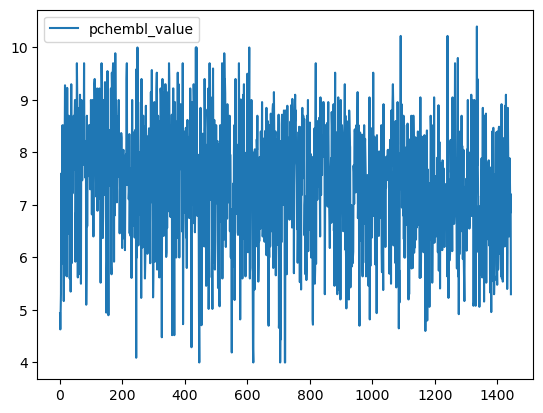

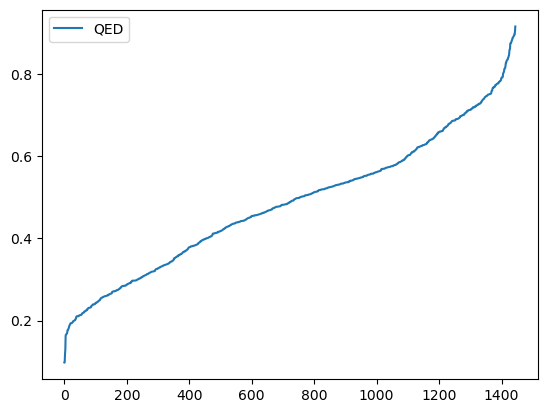

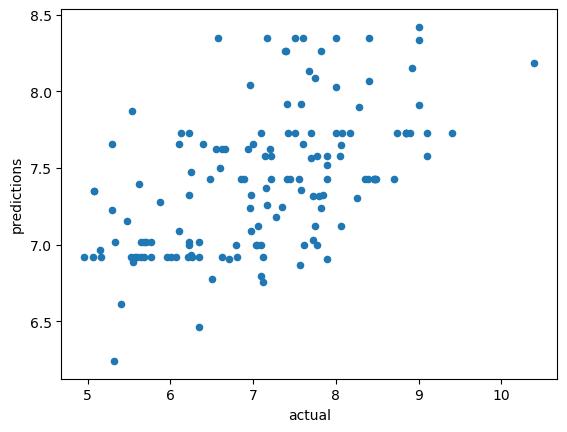

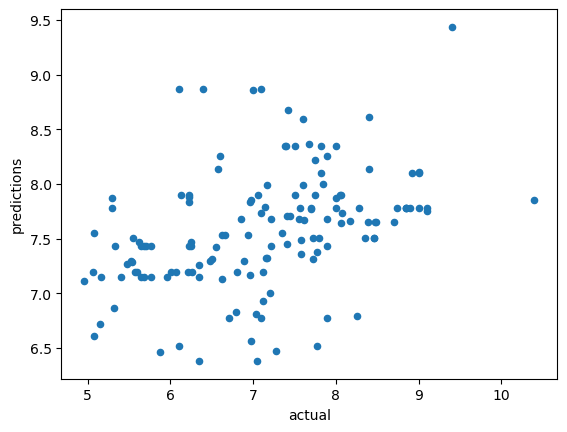

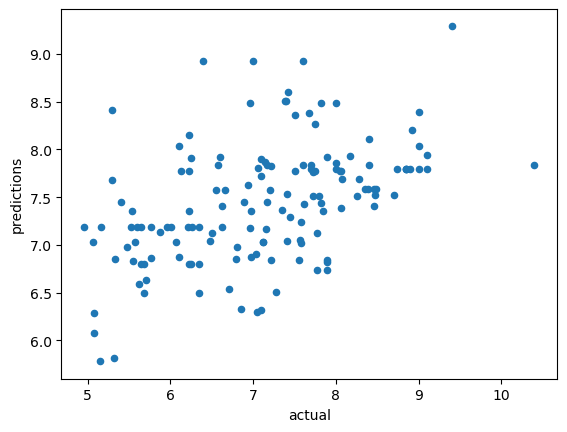

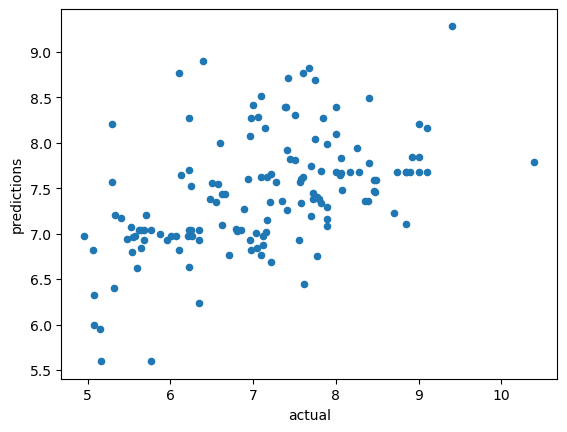

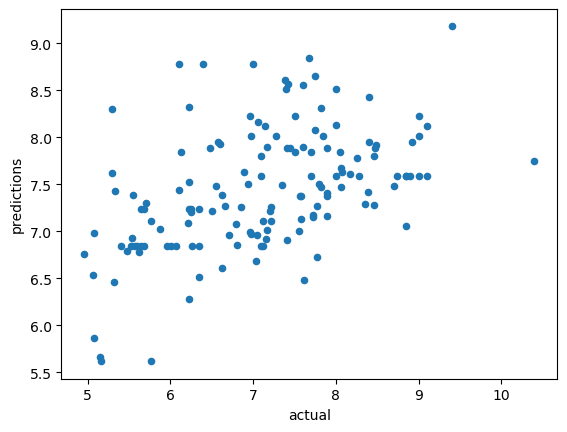

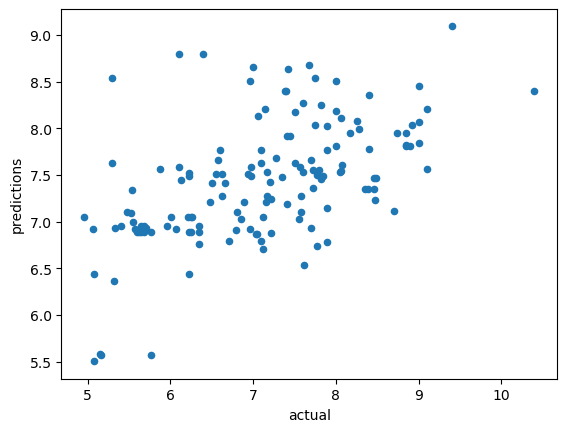

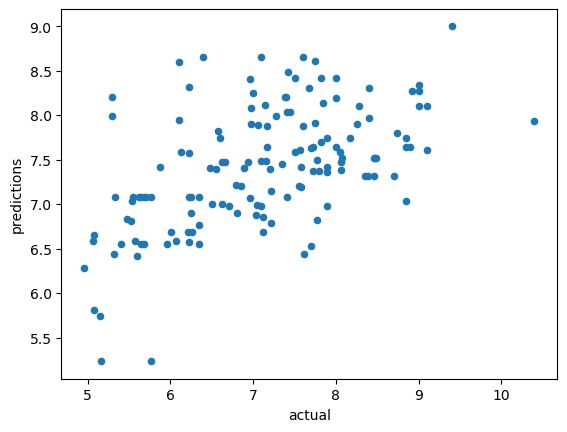

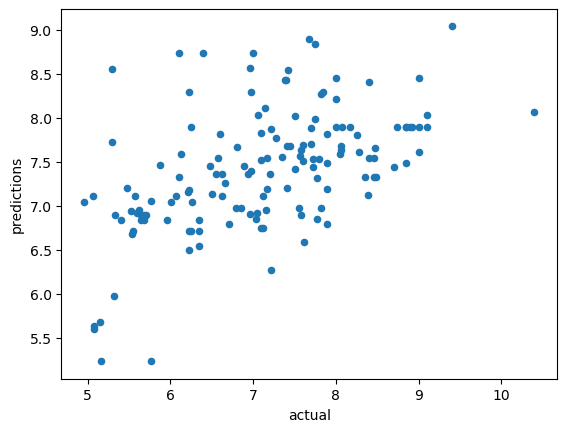

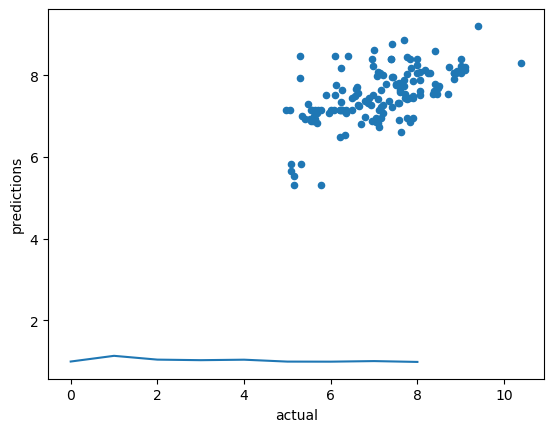

[0.9956659006061461, 1.1351551090341256, 1.04235078640679, 1.028805826469843, 1.0406022916351576, 0.99399568836572, 0.9923864656546902, 1.0064393220310002, 0.986131970470058]


In [24]:
plt.plot(rmse)
plt.show()
print(rmse)